In [2]:
import numpy as np
import pandas as pd
import json
import time # for time measuring
import datetime # for time printing

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

# Machine Learning
from sklearn import preprocessing, svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
def str_to_int(string):
    '''cut away first character and convert to int - used to convert Gesture IDs like "G01" to 1'''
    return int(string[1:])

In [4]:
def timestr(seconds):
    ''' returns HH:MM:ss formatted time string for given seconds
    (seconds can be a float with milliseconds included, but only the integer part will be used)
    :return: string
    '''
    return str(datetime.timedelta(seconds=int(seconds)))

## Read Data

In [5]:
# main data
csv_file = 'data/EXPORT_09042017173622.csv'

# json files to translate gestures, parcours into long text
#gestures_file = 'data/gestures.json' # this is the file edited manually by us to conform to json
gestures_file = 'data/gestures.json.orig' # this is the file edited manually by us to conform to json
parcours_file = 'data/parcours.json'
mutations_file = 'data/mutations.json'

files = (gestures_file, parcours_file, mutations_file)
dataframes = []

# NOTE THAT THESE JSON FILES ARE NOT JSON CONFORM
# each line is a json string on its own, so we need to process the json line by line and combine THEN into a list

In [6]:
def get_oid(oid_dict):
    # get from the original representation {u'$oid': u'589c8ed31337b5ab1e1be121'} just the oid
    return oid_dict['$oid']

In [8]:
# get meta-files with descriptions of gestures, parcours and mutations
for filename in files:
    with open(filename) as f:
        lines = [line.rstrip('\n') for line in f]   # .decode("utf-8")

    lines = [json.loads(line) for line in lines]
    
    # convert list of json lines into Dataframe
    df = pd.DataFrame.from_dict(lines)
    
    # convert long $oid to short
    df['_id'] = df['_id'].apply(get_oid)
    
    # set the real id
    df.set_index('id', inplace=True)
    
    # convert index (ID) from string like 'G01' to int
    df.index = df.index.map(str_to_int)
    
    dataframes.append(df)

In [9]:
(gestures_df, parcours_df, mutations_df) = tuple(dataframes)

In [10]:
gestures_df

,_id,isGarbage,isNesture,name,slug
id,,,,,
1,58a23a22d826756404709446,NaN,NaN,Single Rotation klein rechtsrum,rssr
2,58a23a22d826756404709447,NaN,NaN,Single Rotation klein linksrum,rssl
3,58a23a22d826756404709448,NaN,NaN,Oszillierende Rotation klein rechtsrum,rosr
4,58a23a22d826756404709449,NaN,NaN,Oszillierende Rotation klein linksrum,rosl
5,58a23a22d82675640470944a,NaN,NaN,Single Rotation groß rechtsrum,rsbr
6,58a23a22d82675640470944b,NaN,NaN,Single Rotation groß linksrum,rsbl
7,58a23a22d82675640470944c,NaN,NaN,Oszillierende Rotation groß rechtsrum,robr
8,58a23a22d82675640470944d,NaN,NaN,Oszillierende Rotation groß linksrum,robl
9,58a23a22d82675640470944e,NaN,NaN,Kontinuierliche Rotation groß rechtsrum,rcbr


In [13]:
#gestures_df.to_csv('data/gestures.csv', sep=';', encoding='utf-8')

In [14]:
# "positive" gestures to recognize (not nestures)
gestures_pos = gestures_df[gestures_df['isNesture'] != True].index.tolist()
gestures_pos

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [15]:
parcours_df

,_id,comment,exercises,pose
id,,,,
101,589c897d1337b5ab1e1be118,Zwinge X locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
102,589c8ba71337b5ab1e1be11c,Zwinge X locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
103,589c8dbd1337b5ab1e1be11f,Zwinge X locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
104,589c8ed31337b5ab1e1be121,Zwinge X fest links- und rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
105,589c8fcc1337b5ab1e1be125,Zwinge X oszilierend linksdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
106,589c901a1337b5ab1e1be127,Zwinge X oszilierend rechtsdrehen,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
107,589c90e31337b5ab1e1be12c,Zwinge Y locker rechtsdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
108,589c911c1337b5ab1e1be12e,Zwinge Y locker linksdrehen einzeln 5x,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...
109,589c91961337b5ab1e1be132,Zwinge Y locker rechts- und linksdrehen einzel...,"[{u'signal': {u'beep': True}, u'mutation': {u'...",{u'start': u'Host 008 ist auf Werkbank fixiert...


In [18]:
parcours_df.loc[101,'exercises']

[{u'mutation': {u'id': u'M151'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M152'}, u'signal': {u'beep': True}},
 {u'mutation': {u'id': u'M101'}, u'signal': {u'beep': True}}]

In [19]:
parcours_df.loc[101,'pose']

{u'start': u'Host 008 ist auf Werkbank fixiert, Griffachse X, untere Spannbacke fixiert (Xcm), Gewinde genau in Mitte. Subject steht frontal vor Werkbank, etwas links von Host, F\xfc\xdfe in Schulterbreite, Arme h\xe4ngen locker hinunter.'}

In [20]:
mutations_df

,_id,hands,params,slug
id,,,,
101,58a24ffa5097dc5998d3c5d0,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabaaaba
102,58a24ffa5097dc5998d3c5d1,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaaabababa
103,58a24ffa5097dc5998d3c5d2,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbaaaba
104,58a24ffa5097dc5998d3c5d3,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaabbababa
105,58a24ffa5097dc5998d3c5d4,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaacbaabba
106,58a24ffa5097dc5998d3c5d5,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaaaaadbabbba
107,58a24ffa5097dc5998d3c5d6,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabaaaba
108,58a24ffa5097dc5998d3c5d7,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaaabababa
109,58a24ffa5097dc5998d3c5d8,"{u'right': {u'host': {u'spot': {u'id': u'A', u...","[{u'slug': u'm0', u'value': u'stehend', u'labe...",aaabaabbaaaba


In [24]:
mutations_df.loc[151,'hands']

{u'right': {u'gesture': {u'id': u'G15'},
  u'host': {u'id': u'H008', u'name': u'Schraubzwinge klein'},
  u'instruction': u'zu Griff f\xfchren, greifen mit Faust'}}

In [25]:
mutations_df.loc[152,'hands']

{u'right': {u'gesture': {u'id': u'G17'},
  u'host': {u'id': u'H008', u'name': u'Schraubzwinge klein'},
  u'instruction': u'Umgreifen (Hand l\xf6sen, 90\xb0 Linksdrehung, Host mit Faust-Handhaltung erneut greifen)'}}

In [26]:
mutations_df.loc[101,'hands']

{u'right': {u'gesture': {u'id': u'G01'},
  u'host': {u'id': u'H008',
   u'name': u'Schraubzwinge klein',
   u'spot': {u'id': u'A', u'name': u'Drehgriff'}},
  u'instruction': u'Zwinge X locker rechtsdrehen einzeln'}}

In [28]:
mutations_df.loc[101,'hands']['right']['gesture']['id']

u'G01'

In [27]:
mutations_df.loc[101,'params']

[{u'label': u'K\xf6rperhaltung', u'slug': u'm0', u'value': u'stehend'},
 {u'label': u'Spot', u'slug': u'm1', u'value': u'Drehgriff'},
 {u'label': u'Position Spot', u'slug': u'm2', u'value': u'mittig vor Subject'},
 {u'label': u'Orientierung Spot', u'slug': u'm3', u'value': u'Griffachse X'},
 {u'label': u'ausf\xfchrende Hand', u'slug': u'm4', u'value': u'Rechte'},
 {u'label': u'Handhaltung', u'slug': u'm5', u'value': u'Faust'},
 {u'label': u'Widerstand', u'slug': u'm6', u'value': u'keiner'},
 {u'label': u'Drehweise',
  u'slug': u'm7',
  u'value': u'ganze Hand mitbewegen, ganze Hand umgreifen'},
 {u'label': u'Drehwinkel', u'slug': u'm8', u'value': u'90\xb0'},
 {u'label': u'Drehrichtung',
  u'slug': u'm9',
  u'value': u'rechtsrum (schlie\xdfen)'},
 {u'label': u'Bewegungsablauf', u'slug': u'm10', u'value': u'einzeln'},
 {u'label': u'2. Hand', u'slug': u'm11', u'value': u'ruht woanders'}]

In [30]:
mutations_df.loc[151]

_id                                58a250245097dc5998d3c657
hands     {u'right': {u'host': {u'id': u'H008', u'name':...
params                                                  NaN
slug                                        Start - Greifen
Name: 151, dtype: object

### Define handy function shortcuts

In [71]:
def gesture_name(gesture_id):
    if gesture_id is None: return None
    return gestures_df.loc[gesture_id,'name']

In [74]:
def get_mutation_gesture(mutation_id):
    return str_to_int(mutations_df.ix[mutation_id,'hands']['right']['gesture']['id'])

## Read Experiment Data

In [31]:
# Experiment Data
data = pd.read_csv(csv_file)
data.shape

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1435576, 26)

In [32]:
data.columns

Index([u'Trainset-ID', u'Experiment-ID', u'Subject-ID', u'Observer-ID',
       u'collectedByHand', u'Collector-ID', u'TimeStamp', u'RFID-ID',
       u'GRASP-A', u'GRASP-B', u'GRASP-C', u'AX', u'AY', u'AZ', u'EX', u'EY',
       u'EZ', u'USERINPUT', u'HANDINGLOVE', u' Parcours-ID', u'Parcours-Step',
       u'Mutation-ID', u' Mutation/HandIsActive', u'Host-ID', u'Host/Spot-ID',
       u'Gesture-ID'],
      dtype='object')

In [33]:
data.dtypes

Trainset-ID                object
Experiment-ID              object
Subject-ID                 object
Observer-ID                object
collectedByHand            object
Collector-ID               object
TimeStamp                   int64
RFID-ID                    object
GRASP-A                     int64
GRASP-B                     int64
GRASP-C                     int64
AX                        float64
AY                        float64
AZ                        float64
EX                        float64
EY                        float64
EZ                        float64
USERINPUT                    bool
HANDINGLOVE                  bool
 Parcours-ID               object
Parcours-Step               int64
Mutation-ID                object
 Mutation/HandIsActive       bool
Host-ID                    object
Host/Spot-ID               object
Gesture-ID                 object
dtype: object

In [34]:
data.head()

,Trainset-ID,Experiment-ID,Subject-ID,Observer-ID,collectedByHand,Collector-ID,TimeStamp,RFID-ID,GRASP-A,GRASP-B,...,EZ,USERINPUT,HANDINGLOVE,Parcours-ID,Parcours-Step,Mutation-ID,Mutation/HandIsActive,Host-ID,Host/Spot-ID,Gesture-ID
0,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,0,000000000000,781,8,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
1,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,19896,000000000000,212,213,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
2,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,29001,000000000000,782,0,...,-81.9375,False,True,P101,1,M151,True,H008,NaN,G15
3,_TRAINSET14022017094616,E001,Andreas,Clemens,left,L01,29823,000000000000,179,185,...,-84.5625,False,False,P101,1,M151,False,NaN,NaN,NaN
4,_TRAINSET14022017094616,E001,Andreas,Clemens,right,R01,46136,000000000000,782,6,...,-81.8750,False,True,P101,1,M151,True,H008,NaN,G15


## Some Data Stats

In [35]:
# how many subjects
subjects = data['Subject-ID'].unique().tolist()
subjects 

['Andreas', 'Alfred', 'Claudia', 'Dominik']

In [36]:
# how many observers
data['Observer-ID'].unique().tolist()

['Clemens']

In [37]:
# how many hands
data['Collector-ID'].unique().tolist()

['R01', 'L01']

In [38]:
# how many RFID ids
data['RFID-ID'].unique().tolist()

['000000000000',
 '09006734114B',
 0,
 '05003DD5CD20',
 '760057911BAB',
 '13005E4BB7B1',
 '1400135B8AD6',
 '14001486BE38',
 '7600577D0D51',
 '140014CD1AD7',
 '280015E55981',
 '05008C2F993F']

In [39]:
# how many experiments
experiments = data['Experiment-ID'].unique().tolist()
experiments

['E001', 'E002', 'E003', 'E004', 'E005', 'E006', 'E007', 'E008']

In [40]:
# how many training sets
len(data['Trainset-ID'].unique().tolist())

539

In [41]:
# how many parcours
len(data[' Parcours-ID'].unique())

116

In [42]:
data[' Parcours-ID'].unique()

array(['P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108',
       'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P401', 'P402', 'P403', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'P207', 'P208', 'P211', 'P212', 'P213',
       'P216', 'P217', 'P218', 'P221', 'P222', 'P223', 'P226', 'P227',
       'P228', 'P701', 'P702', 'P705', 'P706', 'P709', 'P710', 'P713',
       'P714', 'P801', 'P802', 'P601', 'P602', 'P603', 'P606', 'P607',
       'P608', 'P611', 'P612', 'P613', 'P616', 'P617', 'P618', 'P621',
       'P622', 'P623', 'P501', 'P502', 'P504', 'P503', 'P301', 'P302',
       'P306', 'P307', 'P308', 'P311', 'P312', 'P316', 'P317', 'P318',
       'P321', 'P322', 'P326', 'P327', 'P328', 'P119', 'P120', 'P121',
       'P231', 'P232', 'P234', 'P233', 'P236', 'P235', 'P717', 'P718',
       'P719', 'P720', 'P721', 'P722', 'P723', 'P724', 'P626', 'P627',
       'P628', 'P629', 'P630', 'P331', 'P332', 'P333', 'P334', 'P335',
      

In [43]:
# how many parcours steps
data['Parcours-Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [44]:
# how many mutations
len(data['Mutation-ID'].unique())

177

In [45]:
# how many gestures
len(data['Gesture-ID'].unique())

19

In [46]:
# which gestures exist
sorted(data['Gesture-ID'].unique())

[nan,
 'G01',
 'G02',
 'G03',
 'G04',
 'G05',
 'G06',
 'G07',
 'G08',
 'G09',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17',
 'G18']

In [47]:
# how many hosts
len(data['Host-ID'].unique())

10

In [50]:
# which hosts
data['Host-ID'].unique()

array(['H008', nan, 'H036', 'H122', 'H011', 'H038', 'H070', 'H127', 'H121',
       'H001'], dtype=object)

In [48]:
# which Host Spots
data['Host/Spot-ID'].unique().tolist()

[nan, 'A', 'B', 'F']

## Data Preprocessing

In [51]:
# rename some columns as the - in the column name does not allow for data.query()) to be used
# cut off the "-ID" suffix, remove a leading space and replace - by _

for col in data.columns:
    if col.endswith('-ID'):
        data.rename(columns={col: col[:-3]}, inplace=True)
        print "Renamed", col, "->", col[:-3]
        col = col[:-3]
    if col.startswith(' '):
        data.rename(columns={col: col[1:]}, inplace=True)
        print "Renamed", col, "->", col[1:]
        col = col[1:]
    if '-' in col:
        new_col = col.replace('-','_')
        data.rename(columns={col: new_col}, inplace=True)
        print "Renamed", col, "->", new_col

Renamed Trainset-ID -> Trainset
Renamed Experiment-ID -> Experiment
Renamed Subject-ID -> Subject
Renamed Observer-ID -> Observer
Renamed Collector-ID -> Collector
Renamed RFID-ID -> RFID
Renamed GRASP-A -> GRASP_A
Renamed GRASP-B -> GRASP_B
Renamed GRASP-C -> GRASP_C
Renamed  Parcours-ID ->  Parcours
Renamed  Parcours -> Parcours
Renamed Parcours-Step -> Parcours_Step
Renamed Mutation-ID -> Mutation
Renamed  Mutation/HandIsActive -> Mutation/HandIsActive
Renamed Host-ID -> Host
Renamed Host/Spot-ID -> Host/Spot
Renamed Gesture-ID -> Gesture


In [52]:
# remove rows that are not needed:
# all where Gesture-ID is NaN  (implies 'Mutation/HandIsActive' == False and Host is NaN)

data.dropna(axis=0, subset=['Gesture'], inplace=True)

In [53]:
# remove columns that we don't need
# to be ignored as communicated by MOM
cols_to_remove = ['Trainset','USERINPUT', 'HANDINGLOVE', 'Observer','Collector','RFID','Parcours_Step',
                  'Mutation/HandIsActive']

data.drop(cols_to_remove,inplace=True,axis=1)

In [54]:
data.shape

(780299, 18)

In [55]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,E001,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,P101,M151,H008,NaN,G15
2,E001,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,P101,M151,H008,NaN,G15
4,E001,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,P101,M151,H008,NaN,G15
6,E001,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,P101,M151,H008,NaN,G15
8,E001,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,P101,M151,H008,NaN,G15


In [56]:
# also in this evaluation, we use only one-hand devices and only people who are right-handers
data['collectedByHand'].unique().tolist()

['right', 'left']

In [57]:
# right hand data rows
sum(data['collectedByHand']=='right')

711360

In [58]:
# left hand data rows
sum(data['collectedByHand']=='left')

68939

In [60]:
# REMOVE left hand data, keep only right hand
data = data[data['collectedByHand']=='right']
data.shape

(711360, 18)

### Convert Columns with String IDs to numbers, for later improved efficiency

In [61]:
cols_to_convert = ['Experiment','Parcours','Mutation','Host','Gesture']

for c in cols_to_convert:
    data[c] = data[c].apply(str_to_int)

In [62]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,1,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,151,8,NaN,15
2,1,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,151,8,NaN,15
4,1,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,151,8,NaN,15
6,1,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,151,8,NaN,15
8,1,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,151,8,NaN,15


## Look into the Data

In [63]:
data.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
0,1,Andreas,right,0,781,8,797,0.06,-0.02,-0.10,216.8125,9.0625,-81.9375,101,151,8,NaN,15
2,1,Andreas,right,29001,782,0,799,0.09,-0.04,-0.11,217.0625,9.0625,-81.9375,101,151,8,NaN,15
4,1,Andreas,right,46136,782,6,798,0.12,-0.09,0.09,217.4375,9.1250,-81.8750,101,151,8,NaN,15
6,1,Andreas,right,74902,784,7,798,0.08,-0.08,0.03,217.6250,9.1250,-81.8125,101,151,8,NaN,15
8,1,Andreas,right,97663,781,0,798,0.07,-0.09,0.04,217.9375,9.1875,-81.7500,101,151,8,NaN,15


In [64]:
data.columns

Index([u'Experiment', u'Subject', u'collectedByHand', u'TimeStamp', u'GRASP_A',
       u'GRASP_B', u'GRASP_C', u'AX', u'AY', u'AZ', u'EX', u'EY', u'EZ',
       u'Parcours', u'Mutation', u'Host', u'Host/Spot', u'Gesture'],
      dtype='object')

### Get Experiment data: Filter for one experiment of one subject (just for testing)

In [65]:
def get_experiment(data,experiment,subject,parcours,mutation,gesture):
    query = []
    # by passing None, some parts of these can be omitted (returning more data)
    if experiment: query.append('Experiment==@exp')
    if subject: query.append('Subject==@subject')
    if parcours: query.append('Parcours==@parcours')
    if mutation: query.append('Mutation==@mutation')
    if gesture: query.append('Gesture==@gesture')
    # TODO filter by Parcours_Step u/o Host
    
    query = " and ".join(query)
    #print query
    return data.query(query)

In [82]:
# get experiment data (setting one to None does not filter by it)
exp = 1
subject = 'Andreas'
parcours = 102
mutation = None
gesture = None #2 # 1

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)
mydata.shape

(664, 18)

In [67]:
# if we queried without Parcours, use this to get all the Parcours
mydata['Parcours'].unique().tolist()

[102]

In [68]:
mut_list = mydata['Mutation'].unique().tolist()
mut_list

[151, 102, 153]

In [69]:
gest_list = mydata['Gesture'].unique().tolist()
gest_list

[15, 2, 17]

In [75]:
for mut in mut_list:
    gest = get_mutation_gesture(mut)
    print mut, ":", gest, gesture_name(gest)

151 : 15 Greifen
102 : 2 Single Rotation klein linksrum
153 : 17 Umgreifen


In [83]:
# how often does the Timestamp jump, i.e. start at 0 again?
sum(mydata['TimeStamp'].diff() < 0)

0

In [76]:
# get data for 1 gesture
mutation = None
gesture = 15 
mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)
mydata.head()

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
2477,1,Andreas,right,0,790,10,809,1.29,0.15,-0.24,236.0000,4.1250,-82.5000,102,151,8,NaN,15
2480,1,Andreas,right,31090,789,0,807,1.53,0.39,0.19,236.0625,3.7500,-83.0625,102,151,8,NaN,15
2482,1,Andreas,right,55174,789,0,808,1.14,0.62,0.64,235.9375,3.5625,-83.7500,102,151,8,NaN,15
2484,1,Andreas,right,77280,788,12,808,1.07,0.44,0.63,235.8125,3.6250,-83.8750,102,151,8,NaN,15
2485,1,Andreas,right,97476,789,9,808,1.02,0.30,0.53,235.5625,3.8125,-83.8125,102,151,8,NaN,15


In [77]:
### Check TimeStep deltas
# investigate time stamp mean and variance
print mydata['TimeStamp'].diff().mean()
mydata['TimeStamp'].diff().describe()

86341.2010309


count    1.940000e+02
mean     8.634120e+04
std      8.733617e+05
min      9.640000e+02
25%      1.617700e+04
50%      2.396850e+04
75%      2.926025e+04
max      1.218731e+07
Name: TimeStamp, dtype: float64

In [81]:
# how often does the Timestamp jump, i.e. start at 0 again?
sum(mydata['TimeStamp'].diff() < 0)

0

### DEBUG TEST: check multiple Parcours of 1 user

In [85]:
# get experiment data (setting one to None does not filter by it)
exp = 1
subject = 'Andreas'
parcours = None #102
mutation = None
gesture = None #2 # 1

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)
mydata.shape

(66713, 18)

In [88]:
# how many parcours in this experiment
len(mydata['Parcours'].unique().tolist())

57

In [86]:
# how often does the Timestamp jump, i.e. start at 0 again?
sum(mydata['TimeStamp'].diff() < 0)

93

In [114]:
# WHY 93 times and not with each parcours???

In [121]:
#one_plot(mydata,'TimeStamp')

In [94]:
cols = ['Experiment','Subject','TimeStamp','Parcours','Mutation','Gesture'] 
mydata2 = mydata[cols]
mydata2

,Experiment,Subject,TimeStamp,Parcours,Mutation,Gesture
0,1,Andreas,0,101,151,15
2,1,Andreas,29001,101,151,15
4,1,Andreas,46136,101,151,15
6,1,Andreas,74902,101,151,15
8,1,Andreas,97663,101,151,15
10,1,Andreas,116448,101,151,15
12,1,Andreas,148753,101,151,15
14,1,Andreas,167422,101,151,15
16,1,Andreas,187481,101,151,15
18,1,Andreas,213733,101,151,15


In [120]:
mydata2.groupby(('Experiment','Subject','Parcours')).first()

TimeStamp  Mutation  Gesture
Experiment Subject Parcours                              
1          Andreas 101               0       151       15
                   102               0       151       15
                   103           18822       151       15
                   104           18846       151       15
                   105            1041       151       15
                   106           12771       151       15
                   107               0       151       15
                   108            1391       151       15
                   109             981       151       15
                   110               0       151       15
                   111               0       151       15
                   112             962       151       15
                   113           20132       151       15
                   114           15131       151       15
                   115           12726       151       15
                   116               0       151       15
                   117            5932       151       15
                   118            2579       151       15
                   201               0       251       15
                   202               0       251       15
                   203           16396       251       15
                   204               0       251       15
                   205               0       251       15
                   206           27443       257       15
                   207            6318       257       15
                   208               0       257       15
                   211               0       251       15
                   212               0       251       15
                   213               0       251       15
                   216            1234       257       15
                   217            1017       257       15
                   218            8760       257       15
                   221               0       251       15
                   222               0       251       15
                   223            7326       251       15
                   226           13667       257       15
                   227           17503       257       15
                   228           30284       257       15
                   401               0       452       15
                   402           22581       452       15
                   403            2283       452       15
                   601           28706       651       15
                   602           10995       651       15
                   603               0       651       15
                   606           13726       651       15
                   607               0       651       15
                   608            5984       651       15
                   701           14252       751       15
                   702            3783       752       15
                   705               0       751       15
                   706            3480       752       15
                   709               0       751       15
                   710               0       752       15
                   713               0       751       15
                   714               0       752       15
                   801               0       851       15
                   802               0       851       15

### Visualize timeline of sensor data of an experiment

In [126]:
params = ['AX', 'AY', 'AZ', 'EX', 'EY', 'EZ', 'GRASP_A', 'GRASP_B', 'GRASP_C']

In [127]:
def one_plot(mydata,var):
    y = mydata[var]
    x = range(len(y))
    #x = mydata['TimeStamp']
    plt.plot(x, y)
    title = "E%s %s P%s M%s G%s %s" % (str(exp),subject,str(parcours),str(mutation),str(gesture),gesture_name(gesture)) 
    plt.title(title)
    #plt.show()

In [128]:
def grid_plot(mydata, title=True):
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10)) #, sharex=True, sharey=True)
    if title is True:
        titlestr = "%s %s %s %s %s %s" % (exp,subject,parcours,mutation,gesture,gesture_name(gesture))
        fig.suptitle(titlestr, fontsize=16)
    elif title is not None:
        fig.suptitle(title, fontsize=16)

    axes_list = axes.reshape(-1)

    for i, var in enumerate(params):

        # data
        y = mydata[var]
        x = range(len(y))
        #x = mydata['TimeStamp']

        # subplot index
        r = i % rows
        c = int(i / rows)
        axes[r,c].plot(x, y)
        axes[r,c].set_title(var)
    

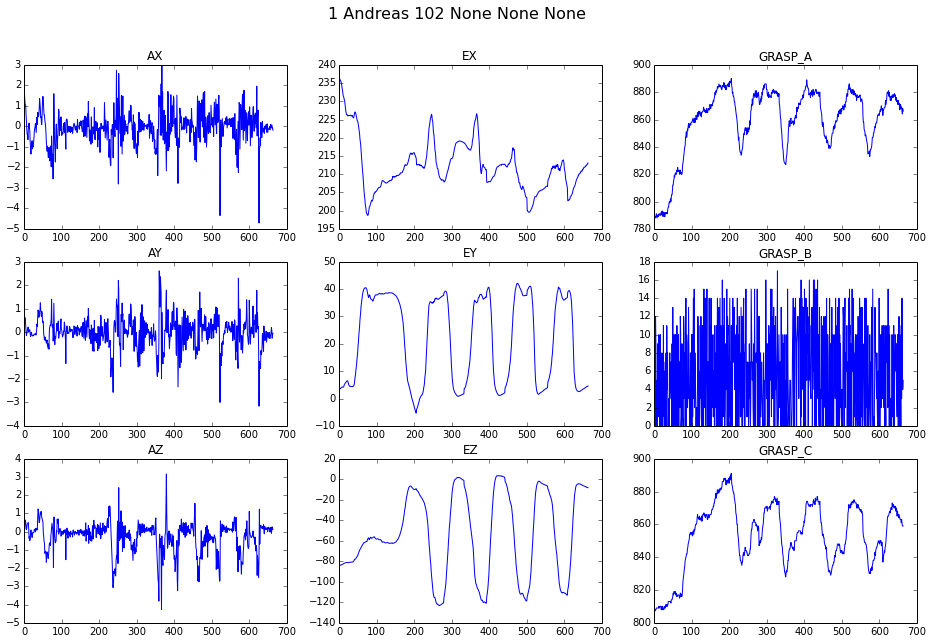

In [129]:
# show data for 1 PARCOURS
exp = 1
subject = 'Andreas'
parcours = 102
mutation = None
gesture = None 

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)

grid_plot(mydata)

Avg. TimeStamp delta: 27686.9441931


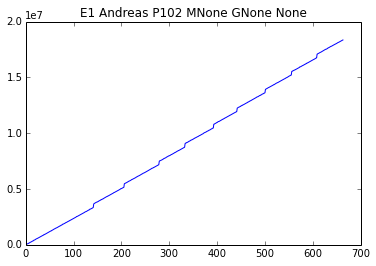

In [130]:
var = 'TimeStamp'
one_plot(mydata,var)
print "Avg. TimeStamp delta:", mydata['TimeStamp'].diff().mean()

#### = Nice continuous data

In [131]:
# which gestures are in this parcours?
gest_list = mydata['Gesture'].unique().tolist()

for g in gest_list:
    print "G", g, gesture_name(g)

G 15 Greifen
G 2 Single Rotation klein linksrum
G 17 Umgreifen


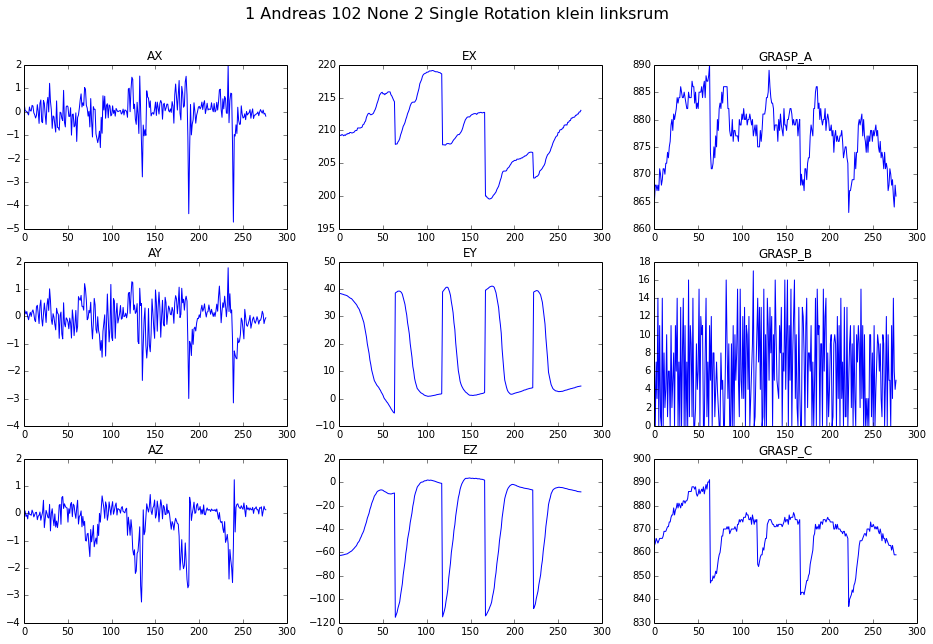

In [132]:
# get data for 1 GESTURE

mutation = None
gesture = 2 

mydata = get_experiment(data,exp,subject,parcours,mutation,gesture)

grid_plot(mydata)

Avg. TimeStamp delta: 53234.3333333


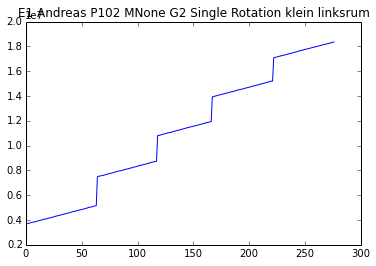

In [133]:
var = 'TimeStamp'
one_plot(mydata,var)
print "Avg. TimeStamp delta:", mydata['TimeStamp'].diff().mean()

#### = Cuts in the data! PROBLEM!!!

#### CONCLUSION: USE PARCOURS DATA - but it may contain multiple gestures - how to group them??

## Make Groupings for each Gesture (by Subject, Experiment, Parcours and Mutation)

In [134]:
# A) GET GESTURES - HAS PROBLEMS WITH CUTS IN THE DATA - SEE ABOVE
# group data nicely, subdivided by Subject, Experiment, Parcours, Mutation, Gesture
group_by = ('Subject','Experiment','Parcours','Mutation','Gesture')
group_df = data.groupby(group_by)
group_df.mean().head(100)  # mean is not meaningful here as aggregation - just to print the structure of the data

TimeStamp     GRASP_A  \
Subject Experiment Parcours Mutation Gesture                             
Alfred  2          101      101      1        1.130901e+07  810.757463   
                            151      15       1.676973e+06  818.471831   
                            152      17       1.167827e+07  827.761290   
                   102      102      2        8.591762e+06  843.431373   
                            151      15       5.716833e+06  800.105634   
                            153      17       7.443301e+06  806.870270   
                   103      101      1        1.122924e+07  814.229508   
                            102      2        1.370922e+07  819.003546   
                            151      15       1.809063e+06  808.169935   
                   104      103      1        1.400507e+07  837.172308   
                            104      2        1.207087e+07  836.213296   
                            151      15       1.352875e+06  801.000000   
                   107      107      1        9.184166e+06  766.794118   
                            151      15       1.187204e+06  780.176471   
                            152      17       9.750877e+06  757.044444   
                   108      108      2        8.678827e+06  806.088235   
                            151      15       4.771863e+06  754.100000   
                            153      17       7.353012e+06  751.086957   
                   109      107      1        8.138213e+06  786.452381   
                            108      2        9.324114e+06  799.341880   
                            151      15       9.717311e+05  795.439024   
                   110      109      1        1.222393e+07  829.140625   
                            110      2        1.031666e+07  811.614545   
                            151      15       1.209033e+06  749.923077   
                   113      113      1        9.110600e+06  749.443396   
                            151      15       9.060722e+05  809.428571   
                            152      17       8.705761e+06  799.256506   
                   114      114      2        8.790661e+06  819.497758   
                            151      15       5.878386e+06  775.845070   
                            153      17       7.409746e+06  784.954545   
...                                                    ...         ...   
                   213      251      15       1.841759e+06  819.839744   
                            252      16       4.672078e+06  806.087719   
                   216      211      1        1.171480e+07  825.902778   
                            252      16       4.509734e+06  832.289474   
                            255      17       1.174701e+07  817.467005   
                            257      15       1.658576e+06  819.588652   
                   217      212      2        1.168402e+07  844.793233   
                            252      16       3.962031e+06  833.413793   
                            256      17       1.181055e+07  830.669767   
                            257      15       1.490184e+06  821.208000   
                   218      211      1        1.125110e+07  837.463668   
                            212      2        1.329698e+07  832.817021   
                            252      16       3.752186e+06  836.448276   
                            257      15       1.384356e+06  822.423729   
                   221      217      1        1.201185e+07  838.536585   
                            251      15       1.742483e+06  811.250000   
                            252      16       4.514727e+06  797.548387   
                            253      17       1.236410e+07  805.244344   
                   222      218      2        1.231034e+07  800.109091   
                            251      15       1.973937e+06  818.753012   
                            252      16       5.204211e+06  849.939759   
                            254      17       1.31330

In [135]:
# EXPERIMENTING... NOT FINAL YET
# B) GET PARCOURS - AVOIDS CUTS IN THE DATA - SEE ABOVE
# group data nicely, subdivided by Subject, Experiment, Parcours, Mutation, Gesture
group_by = ('Subject','Experiment','Parcours')
group_df = data.groupby(group_by)
group_df.mean().head(100)  # mean is not meaningful here as aggregation - just to print the structure of the data

TimeStamp     GRASP_A     GRASP_B     GRASP_C  \
Subject Experiment Parcours                                                     
Alfred  2          101       9.568345e+06  819.600000  768.270833  818.397222   
                   102       7.422826e+06  819.107345  768.632768  814.246704   
                   103       1.022663e+07  814.795946  753.825676  816.132432   
                   104       1.131687e+07  831.546816  687.423221  835.872659   
                   107       8.033683e+06  764.593750  616.944444  785.852431   
                   108       7.227369e+06  773.503861  681.708494  781.345560   
                   109       7.548573e+06  793.587452  672.288973  781.007605   
                   110       9.834732e+06  810.459227  691.082976  812.640916   
                   113       7.783269e+06  781.734767  645.241935  807.931900   
                   114       7.577012e+06  796.802218  690.482440  811.885397   
                   115       8.774588e+06  788.919225  654.344103  820.077544   
                   116       1.064116e+07  823.780025  691.369153  832.218710   
                   201       1.222969e+07  805.685561  696.752941  809.515508   
                   202       1.097932e+07  799.916667  692.759662  802.791063   
                   203       1.023232e+07  817.374670  695.387863  819.829815   
                   206       1.065217e+07  828.671233  680.702366  823.534247   
                   207       1.073597e+07  837.679058  672.591078  830.194548   
                   208       1.031557e+07  838.383508  660.362565  833.748691   
                   211       1.051803e+07  802.732661  628.900378  808.698613   
                   212       1.024014e+07  810.127273  630.818182  813.845455   
                   213       1.029022e+07  814.541722  650.100662  822.994702   
                   216       8.605013e+06  822.622222  659.003175  816.603175   
                   217       9.131457e+06  834.786145  666.843373  823.843373   
                   218       9.653340e+06  833.284286  655.961429  828.421429   
                   221       9.195247e+06  817.949778  641.881832  815.905465   
                   222       9.220983e+06  809.437500  626.662791  814.213663   
                   223       9.456299e+06  810.834049  649.366237  813.525036   
                   226       8.207724e+06  834.607383  664.369128  828.983221   
                   227       9.334056e+06  841.213043  665.657971  832.508696   
                   228       1.032016e+07  834.319737  668.727632  831.502632   
...                                   ...         ...         ...         ...   
                   706       8.814481e+06  806.637255  722.766340  805.310458   
                   709       8.373983e+06  817.883527  751.459235  812.366057   
                   710       8.487823e+06  795.563356  721.107877  794.922945   
                   713       9.587405e+06  815.154066  744.044223  810.808845   
                   714       9.035333e+06  798.847377  668.763116  798.607313   
                   801       1.340403e+07  820.654453  634.278308  803.248295   
                   802       2.201419e+07  811.473777  648.329994  810.403654   
        8          119       3.868247e+07  789.407643  727.621975  780.925159   
                   120       3.155918e+07  760.242063  691.245635  760.367063   
                   121       3.675242e+07  783.458502  739.191633  798.086707   
                   231       4.305471e+07  783.327784  727.733639  785.829793   
                   232       3.144123e+07  820.030989  770.402861  809.809297   
                   233       3.319815e+07  786.305900  730.408869  790.598647   
                   234       3.392449e+07  814.328792  758.709131  801.879602   
                   235       3.830123e+07  793.419501  724.482021  788.939423   
                   236       3.207953e+07  811.043241  752.617063  798.879236   
                   331       3.877063e+07  820.203320  772.4254

In [136]:
# which gestures are in each parcours:

for name_tuple, group_data in group_df:
    print name_tuple, ":", group_data['Gesture'].unique().tolist()
    if name_tuple == ('Alfred', 8, 231): # gestures:  [15, 16, 3, 4]
        test_group_data = group_data

('Alfred', 2, 101) : [15, 1, 17]
('Alfred', 2, 102) : [15, 2, 17]
('Alfred', 2, 103) : [15, 1, 2]
('Alfred', 2, 104) : [15, 2, 1]
('Alfred', 2, 107) : [15, 1, 17]
('Alfred', 2, 108) : [15, 2, 17]
('Alfred', 2, 109) : [15, 1, 2]
('Alfred', 2, 110) : [15, 2, 1]
('Alfred', 2, 113) : [15, 1, 17]
('Alfred', 2, 114) : [15, 2, 17]
('Alfred', 2, 115) : [15, 1, 2]
('Alfred', 2, 116) : [15, 2, 1]
('Alfred', 2, 201) : [15, 16, 1, 17]
('Alfred', 2, 202) : [15, 16, 2, 17]
('Alfred', 2, 203) : [15, 16, 1, 2]
('Alfred', 2, 206) : [15, 16, 1, 17]
('Alfred', 2, 207) : [15, 16, 2, 17]
('Alfred', 2, 208) : [15, 16, 1, 2]
('Alfred', 2, 211) : [15, 16, 1, 17]
('Alfred', 2, 212) : [15, 16, 2, 17]
('Alfred', 2, 213) : [15, 16, 1, 2]
('Alfred', 2, 216) : [15, 16, 1, 17]
('Alfred', 2, 217) : [15, 16, 2, 17]
('Alfred', 2, 218) : [15, 16, 1, 2]
('Alfred', 2, 221) : [15, 16, 1, 17]
('Alfred', 2, 222) : [15, 16, 2, 17]
('Alfred', 2, 223) : [15, 16, 1, 2]
('Alfred', 2, 226) : [15, 16, 1, 17]
('Alfred', 2, 227) : [1

('Claudia', 5, 334) : [15, 16, 3, 4]
('Claudia', 5, 335) : [15, 16, 3, 4]
('Claudia', 5, 336) : [15, 16, 3, 4]
('Claudia', 5, 626) : [15, 16, 7, 8]
('Claudia', 5, 627) : [15, 16, 7, 8]
('Claudia', 5, 628) : [15, 16, 7, 8]
('Claudia', 5, 629) : [15, 16, 7, 8]
('Claudia', 5, 630) : [15, 16, 7, 8]
('Claudia', 5, 717) : [15, 16, 12]
('Claudia', 5, 718) : [15, 16, 12]
('Claudia', 5, 719) : [15, 16, 12]
('Claudia', 5, 720) : [15, 16, 12]
('Claudia', 5, 721) : [15, 16, 12]
('Claudia', 5, 722) : [15, 16, 12]
('Claudia', 5, 723) : [15, 16, 12]
('Claudia', 5, 724) : [15, 16, 12]
('Claudia', 5, 901) : [15, 14, 13, 16]
('Claudia', 5, 902) : [15, 11]
('Claudia', 5, 903) : [15, 11]
('Dominik', 4, 101) : [15, 1, 17]
('Dominik', 4, 102) : [15, 2, 17]
('Dominik', 4, 103) : [15, 1, 2]
('Dominik', 4, 104) : [15, 2, 1]
('Dominik', 4, 107) : [15, 1, 17]
('Dominik', 4, 108) : [15, 2, 17]
('Dominik', 4, 109) : [15, 1, 2]
('Dominik', 4, 110) : [15, 2, 1]
('Dominik', 4, 113) : [15, 1, 17]
('Dominik', 4, 114) :

In [137]:
test_group_data

,Experiment,Subject,collectedByHand,TimeStamp,GRASP_A,GRASP_B,GRASP_C,AX,AY,AZ,EX,EY,EZ,Parcours,Mutation,Host,Host/Spot,Gesture
1279327,8,Alfred,right,0,712,599,721,-0.08,0.00,-0.06,233.0625,7.7500,-83.0000,231,251,122,NaN,15
1279330,8,Alfred,right,30281,713,598,721,-0.07,-0.04,-0.06,233.0625,7.7500,-83.0000,231,251,122,NaN,15
1279331,8,Alfred,right,48921,715,600,722,-0.11,-0.02,-0.04,233.0625,7.7500,-83.0000,231,251,122,NaN,15
1279334,8,Alfred,right,86574,714,601,723,-0.06,0.04,-0.02,233.1250,7.7500,-83.0000,231,251,122,NaN,15
1279336,8,Alfred,right,114279,715,601,723,0.00,0.00,-0.04,233.1250,7.7500,-83.0000,231,251,122,NaN,15
1279337,8,Alfred,right,126855,712,598,722,0.02,0.00,0.00,233.1250,7.6875,-83.0000,231,251,122,NaN,15
1279340,8,Alfred,right,154182,712,599,721,0.00,0.01,-0.05,233.1250,7.6875,-83.0000,231,251,122,NaN,15
1279341,8,Alfred,right,167659,714,600,722,-0.02,0.03,0.00,233.1250,7.6875,-83.0000,231,251,122,NaN,15
1279343,8,Alfred,right,191716,712,599,722,-0.01,-0.01,-0.07,233.1250,7.6875,-83.0000,231,251,122,NaN,15
1279345,8,Alfred,right,216735,713,600,723,0.00,-0.06,-0.04,233.1250,7.6875,-83.0000,231,251,122,NaN,15


## Make Gesture Data Dict

In [138]:
# REAL: now we ITERATE nicely through group_df and get each Gesture block individually
# -> group_data will be a dataframe just for a single gesture

i=0
# dictionary containing a list of sub-datasets for each gesture, to train ML
gesture_exp_dict = {}

for name_tuple, group_data in group_df:
    i += 1
    #print str(name_tuple)
    gesture = name_tuple[-1]  # gesture is last element of tuple, as defined in group_by above
    if gesture not in gesture_exp_dict.keys():
        gesture_exp_dict[gesture] = [] # initalize empty list for this gesture
    # add data to gesture dict
    gesture_exp_dict[gesture].append(group_data)

print "DONE:", i, "gesture blocks"

DONE: 440 gesture blocks


In [470]:
## Older version iterating over experiments - MUCH SLOWER! - UNUSED BUT KEPT FOR EXAMPLE HOW IT CAN BE DONE
# Iterate over Experiments etc. to group data by gestures

def unused():

    # dictionary containing a list of sub-datasets for each gesture, to train ML
    gesture_exp_dict = {}

    experiments = data['Experiment'].unique().tolist()



    for subject in subjects:
        for exp in experiments:

            exp_data = get_experiment(data,exp,subject,parcours=None,mutation=None,gesture=None)

            if exp_data.shape[0] > 0:
                # list of parcours in this experiment
                parc_list = exp_data['Parcours'].unique().tolist()

                print subject, exp, ":", len(parc_list), "parcours"

    #            for parc in parc_list:
                for parc in parc_list[:5]:     # DEBUG: take only first 5 parcours per experiment
                    mydata = get_experiment(data,exp,subject,parc,mutation=None,gesture=None)
                    mutations = exp_data['Mutation'].unique().tolist()
                    gestures = exp_data['Gesture'].unique().tolist() 

                    print "- P", parc, mydata.shape, len(mutations), "mutations", len(gestures), "gestures"

                    for mut in mutations:
                        mydata = get_experiment(data,exp,subject,parc,mut,gesture=None)
                        gestures = mydata['Gesture'].unique().tolist() 

                        for gest in gestures:
                            mydata = get_experiment(data,exp,subject,parc,mut,gest)
                            print mydata.shape
                            # add data to gesture dict
                            if mydata.shape[0] > 0:
                                if gest not in gesture_exp_dict.keys():
                                    gesture_exp_dict[gest] = [] # initalize empty list for this gesture
                                # add data to gesture dict
                                gesture_exp_dict[gest].append(mydata)

    print "FINISHED."

In [139]:
# How many data blocks = training examples do we have for each gestures
for gest in sorted(gesture_exp_dict.keys()):
    print "G", gest, '\t', len(gesture_exp_dict[gest]), "data blocks"

G 101 	4 data blocks
G 102 	4 data blocks
G 103 	4 data blocks
G 104 	4 data blocks
G 105 	1 data blocks
G 106 	1 data blocks
G 107 	4 data blocks
G 108 	4 data blocks
G 109 	4 data blocks
G 110 	4 data blocks
G 111 	1 data blocks
G 112 	1 data blocks
G 113 	4 data blocks
G 114 	4 data blocks
G 115 	4 data blocks
G 116 	4 data blocks
G 117 	1 data blocks
G 118 	1 data blocks
G 119 	4 data blocks
G 120 	4 data blocks
G 121 	4 data blocks
G 201 	4 data blocks
G 202 	4 data blocks
G 203 	4 data blocks
G 204 	1 data blocks
G 205 	1 data blocks
G 206 	4 data blocks
G 207 	4 data blocks
G 208 	4 data blocks
G 211 	4 data blocks
G 212 	4 data blocks
G 213 	4 data blocks
G 216 	4 data blocks
G 217 	4 data blocks
G 218 	4 data blocks
G 221 	4 data blocks
G 222 	4 data blocks
G 223 	4 data blocks
G 226 	4 data blocks
G 227 	4 data blocks
G 228 	4 data blocks
G 231 	4 data blocks
G 232 	4 data blocks
G 233 	4 data blocks
G 234 	4 data blocks
G 235 	4 data blocks
G 236 	4 data blocks
G 301 	4 data

In [472]:
# how many data points (timesteps) does each data block have?

data_sizes = {} # collect per gesture in dict
data_sizes_total = [] # collect all in list

for gest in sorted(gesture_exp_dict.keys()):
    print "G", gest, ':\t', 
    for datablock in gesture_exp_dict[gest]:
        size = datablock.shape[0]
        #print size,
        # TODO data_sizes ...
        data_sizes_total.append(size)
    print

G 1 :	
G 2 :	
G 3 :	
G 4 :	
G 5 :	
G 6 :	
G 7 :	
G 8 :	
G 9 :	
G 10 :	
G 11 :	
G 12 :	
G 13 :	
G 14 :	
G 15 :	
G 16 :	
G 17 :	


In [ ]:
# TODO print length per gestures

In [473]:
# average data length (number of samples)
avg_data_len = int(np.mean(data_sizes_total))
avg_data_len

433

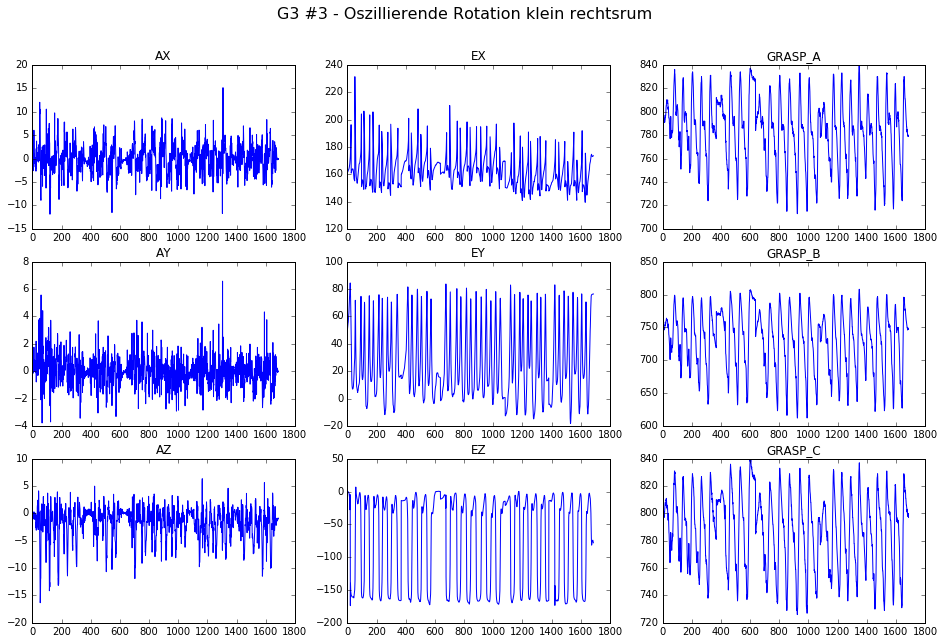

In [563]:
g = 3
i=3
title = "G%d #%d - %s" % (g,i,gesture_name(g))
grid_plot(gesture_exp_dict[g][i], title)

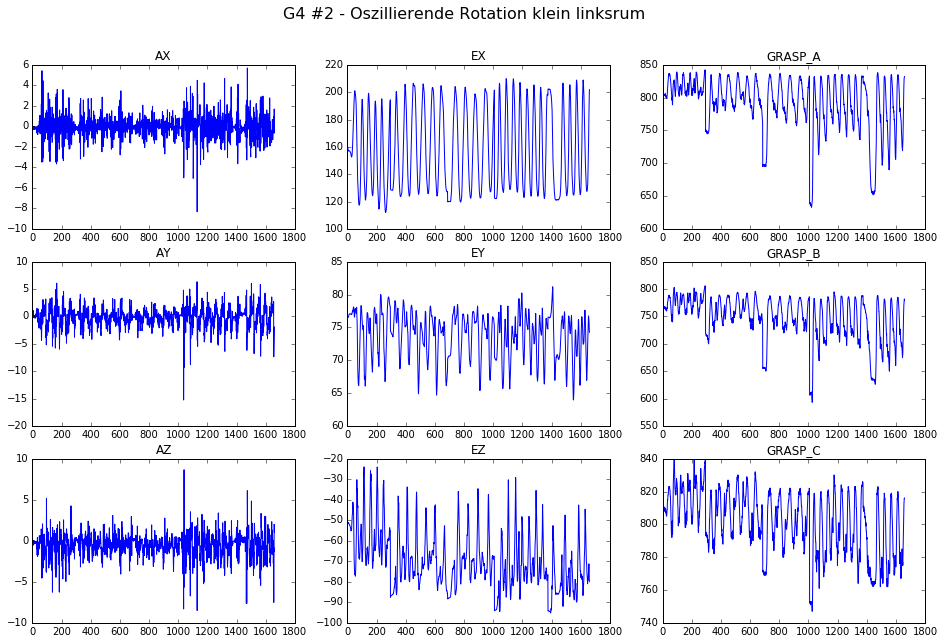

In [564]:
g = 4
i=2
title = "G%d #%d - %s" % (g,i,gesture_name(g))
grid_plot(gesture_exp_dict[g][i], title)

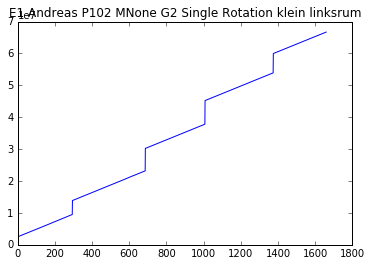

In [565]:
one_plot(gesture_exp_dict[g][i],var='TimeStamp')

### Resampling / Time Normalization - Test

In [477]:
# Time Normalize / Interpolate time stamps
signal_orig = gesture_exp_dict[g][i]['EZ']
signal_orig_timestamps = gesture_exp_dict[g][i]['TimeStamp'].values

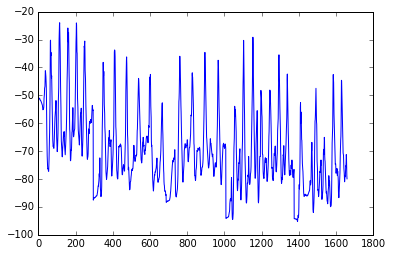

In [478]:
# plot with indices on x
y = signal_orig
plt.plot(range(len(y)), y)

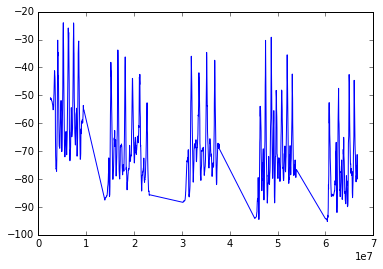

In [479]:
# plot with timestamps on x
plt.plot(signal_orig_timestamps, signal_orig)

In [480]:
signal_orig_timestamps

array([ 2512205,  2513666,  2538667, ..., 66676505, 66686338, 66711162])

In [481]:
from scipy import stats
from scipy.signal import resample

samples = 500 # should relate to avg_data_len

# If t is given, it is assumed to be the sample positions associated with the signal data in x.
signal_resampled = resample(signal_orig, num=samples) # , t=None,

In [482]:
signal_resampled2, timestamps2 = resample(signal_orig, num=samples, t=signal_orig_timestamps)

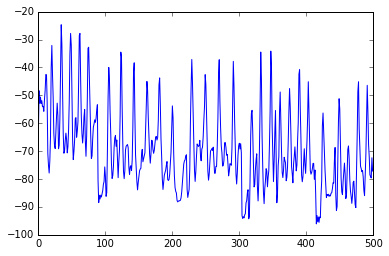

In [483]:
# plot with indices on x
y = signal_resampled
plt.plot(range(len(y)), y)

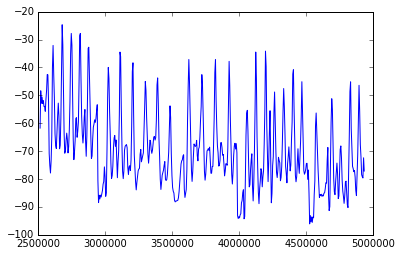

In [484]:
# plot with timestamps on x
y = signal_resampled2
plt.plot(timestamps2, y)

### Resampling / Time Normalization - Batch

In [485]:
# Resample Loop over ALL data

# build new gesture dictionary for resampled data

gesture_exp_dict_res = {}

for gest in sorted(gesture_exp_dict.keys()):
    print "G", gest, ':\t'#, 
    for datablock in gesture_exp_dict[gest]:
        #print datablock.shape[0], 
        
        # we can resample the whole block of in put signals
        # transpose: 6 data rows with params, cols is time series
        in_data = datablock[params].T
        
        # resample the whole block, along cols (axis = 1), to target num samples
        signal_resampled = resample(in_data, num=samples, axis=1)
        
        if gest not in gesture_exp_dict_res.keys():
            gesture_exp_dict_res[gest] = [] # initalize empty list for this gesture
        # add data to gesture dict
        gesture_exp_dict_res[gest].append(signal_resampled)
    #print



G 1 :	
G 2 :	
G 3 :	
G 4 :	
G 5 :	
G 6 :	
G 7 :	
G 8 :	
G 9 :	
G 10 :	
G 11 :	
G 12 :	
G 13 :	
G 14 :	
G 15 :	
G 16 :	
G 17 :	


In [486]:
in_data

,549314,549316,549318,549319,549322,549323,549326,549328,549330,549332,...,550633,550635,550637,550639,550641,550643,550645,550647,550649,550651
AX,-0.23,-0.2600,-0.0200,-0.240,-0.1900,-0.3900,-0.2100,-0.1200,-0.1900,-0.26,...,0.750,-0.8900,-0.6100,-0.5900,-0.1700,0.350,0.3400,0.8700,0.1500,0.3100
AY,0.16,0.0000,0.1900,0.190,0.1700,-0.1600,0.1300,0.1700,0.0200,0.10,...,0.730,0.1700,-0.0100,-0.0100,0.0900,0.120,-0.1500,-0.3800,-0.4200,-0.3500
AZ,-0.09,0.0100,-0.0200,-0.200,-0.0800,-0.2900,-0.3000,0.0400,-0.0300,-0.07,...,-2.470,-0.7200,-0.4400,-0.5900,-0.4400,-0.350,-0.2000,0.1800,0.3100,0.1700
EX,98.25,98.0625,98.1875,98.000,98.0625,98.0000,98.0625,98.0625,98.0625,98.00,...,151.625,151.6250,151.4375,151.3750,151.1875,151.125,151.0625,150.8125,150.6875,150.6875
EY,3.50,3.5000,3.6250,3.625,3.6875,3.6875,3.7500,3.7500,3.7500,3.75,...,12.875,12.7500,12.5000,12.4375,12.5000,12.625,12.7500,12.8750,12.8750,12.9375
EZ,0.75,0.6875,0.6250,0.500,0.3750,0.3750,0.3125,0.2500,0.2500,0.25,...,-7.125,-7.3125,-7.5625,-7.6250,-7.5000,-7.375,-7.2500,-7.0000,-6.8125,-6.7500


In [487]:
in_data.shape

(6, 488)

In [488]:
signal_resampled = resample(in_data, num=samples, axis=1)
signal_resampled

array([[ -2.30000004e-01,  -2.69950721e-01,  -1.58289912e-02, ...,
          8.33122501e-01,   1.39777381e-01,   3.08761364e-01],
       [  1.59999996e-01,  -8.60893652e-03,   1.99998394e-01, ...,
         -3.36294875e-01,  -4.54637665e-01,  -3.25501860e-01],
       [ -9.00000036e-02,  -5.02909150e-03,   1.12098599e-02, ...,
          2.46174871e-01,   2.81646087e-01,   1.75948178e-01],
       [  9.82500000e+01,   9.76606715e+01,   9.87004991e+01, ...,
          1.50088266e+02,   1.51453363e+02,   1.49803577e+02],
       [  3.50000000e+00,   3.42434858e+00,   3.71599440e+00, ...,
          1.27519632e+01,   1.30127698e+01,   1.27805227e+01],
       [  7.50000000e-01,   7.48233717e-01,   5.51949758e-01, ...,
         -6.88682386e+00,  -6.91339262e+00,  -6.62438703e+00]])

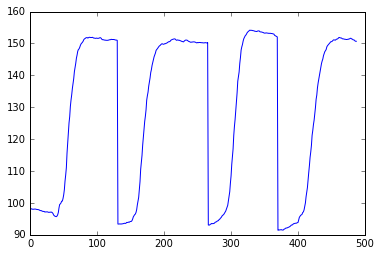

In [489]:
# before
v = 'EX'
y = in_data.ix[v]
plt.plot(range(len(y)), y)

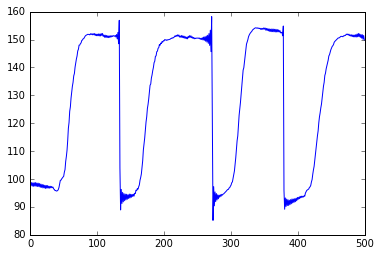

In [490]:
# after
i = in_data.index.get_loc(v)
y = signal_resampled[i,:]
plt.plot(range(len(y)), y)

In [491]:
# TODO optionally scale signal between 0 and 1 or
# TODO Standardize values of signale (0-mean/unit-var)

In [492]:
in_data.shape

(6, 488)

### Testing: Calc Derivative Signal of EX, EY, EZ

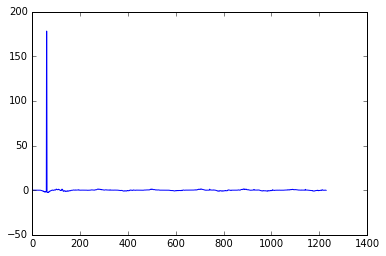

In [449]:
# Calc derivatives 

v = 'EX'
y = in_data.ix[v]

y_d = np.gradient(y) 
plt.plot(range(len(y_d)), y_d)

In [452]:
# can we do it on the matrix of input signals?
in_data_deriv = np.gradient(in_data, axis=1)
in_data_deriv.shape

(6, 1230)

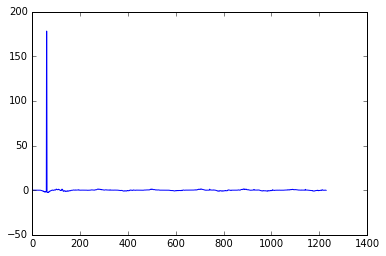

In [453]:
# deriv from full matrix
i = in_data.index.get_loc(v)
y = in_data_deriv[i,:]
plt.plot(range(len(y)), y)

#### -> Problem with Artefacts!

### Feature Calculation

#### Statistical Features, Derivative

In [566]:
# Calc statistical features

def calc_statistical_features(matrix):

    result = np.zeros((matrix.shape[0],7))
    
    result[:,0] = np.mean(matrix, axis=1)
    result[:,1] = np.var(matrix, axis=1, dtype=np.float64) 
    result[:,2] = stats.skew(matrix, axis=1)
    result[:,3] = np.median(matrix, axis=1)
    result[:,4] = np.min(matrix, axis=1)
    result[:,5] = np.max(matrix, axis=1)
    result[:,6] = stats.kurtosis(matrix, axis=1, fisher=False) # Matlab calculates Pearson's Kurtosis

    result[np.where(np.isnan(result))] = 0
    return result

In [596]:
# OPTIONS:

use_resampled = False
exclude_non_gestures =True
calc_derivative = False

In [597]:
if use_resampled:
    input_dict = gesture_exp_dict_res # resampled
else:
    input_dict = gesture_exp_dict # non resampled

In [598]:
if exclude_non_gestures:
    gestures_to_process = gestures_pos
else:
    gestures_to_process = input_dict.keys()

In [599]:
# LOOP over all gesture data to create features

# initialize feature output for training data as a list
train_list = []
train_classes_num = []


for gest in sorted(gestures_to_process):
    print "G", gest, ':\t', len(input_dict[gest]), "examples"
    for datablock in input_dict[gest]:
        #print datablock.shape, 
        
        if use_resampled:
            # resampled data has already extracted the param columns
            in_data = datablock
        else:
            # for non-resampled we have to get the relevant data columns and transpose
            in_data = datablock[params].T

        # calc statistical features
        features = calc_statistical_features(in_data)
        #features.shape
 
        # vectorize
        features = features.flatten()
        
        if calc_derivative:
            # calc derivative of all signals
            in_data_deriv = np.gradient(in_data, axis=1)
            # calc statistics of derivatives
            features_deriv = calc_statistical_features(in_data)
            # vectorize
            features_deriv = features_deriv.flatten()
            # concatenate to other features
            features = np.concatenate((features,features_deriv))
        
        # append to output
        train_list.append(features)
        
        # store class for these features
        train_classes_num.append(gest)
        
        
    #print

G 1 :	120 examples
G 2 :	120 examples
G 3 :	64 examples
G 4 :	64 examples
G 5 :	60 examples
G 6 :	60 examples
G 7 :	20 examples
G 8 :	20 examples
G 9 :	4 examples
G 10 :	4 examples
G 11 :	100 examples
G 12 :	32 examples
G 13 :	12 examples


In [600]:
in_data.shape

(9, 362)

### TODO Add more features

In [601]:
# TODO measure ZCR
# ZCR=mean(abs(diff(sign(Signal))) # Matlab code


In [602]:
print "Training data:", len(train_list), "examples"

Training data: 680 examples


In [603]:
# make feature array from feature list (ALL training data)

train_data = np.array(train_list)
#del train_list
train_data.shape

(680, 63)

In [604]:
len(train_classes_num)

680

In [605]:
train_classes_num

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


### Standardize

In [606]:
train_data = preprocessing.scale(train_data,axis=0)
# axis=0 means independently standardize each feature, otherwise (if 1) standardize each sample

## Machine Learning

In [607]:
# split the data into train/test set

testset_size = 0.25

# sklearn >= 0.18
# use random_state to avoid that the results fluctuate randomly
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0) 
splits = splitter.split(train_data, train_classes_num)

# Note: this for loop is only executed once, if n_splits==1
for train_index, test_index in splits:
    #print "TRAIN INDEX:", train_index
    #print "TEST INDEX:", test_index
    
    # split the data
    train_set = train_data[train_index]
    test_set = train_data[test_index]
    
    # and the numeric classes (groundtruth)
    train_classes = np.array(train_classes_num)[train_index]
    test_classes = np.array(train_classes_num)[test_index]
    
    print "TRAIN SIZE:", train_set.shape
    print "TEST SIZE:", test_set.shape
    

TRAIN SIZE: (510, 63)
TEST SIZE: (170, 63)


## Tasks

### 1) Recognize Host + Gesture

(maybe also Subject)

### 2) Recognize Gesture independent of host

In [608]:
# TRAIN 
start_time = time.time() # measure time

model = OneVsRestClassifier(SVC(kernel='linear')) #, n_jobs=-1)  # n_jobs = n cpus, -1 = all
# full set
#model.fit(train_data, train_classes_num)
# train set
model.fit(train_set, train_classes)

end_time = time.time()
print "Training time:", timestr(end_time - start_time)

Training time: 0:00:00


In [609]:
# predict on train set

pred_train = model.predict(train_set)
pred_train

array([11, 12,  6,  1,  1,  2,  5,  1, 11,  8,  2,  1,  6,  1,  4,  4,  1,
       11,  1, 12,  2,  2,  1,  3,  3,  6, 13,  5,  2,  4,  5,  1,  2,  4,
        1, 11,  1,  6,  7,  1,  2,  2, 11,  1,  2,  2,  5, 12,  6, 11, 12,
        4, 11,  2,  1,  8,  2,  1, 13, 11, 11,  2,  3,  1,  7, 11,  1,  2,
        2,  1, 11,  3,  3, 11,  2,  2,  2,  2,  1,  4,  6,  1,  6, 11,  2,
        1,  2,  2,  8, 11,  1,  7,  3,  6, 11,  2,  7,  5,  5,  2, 11,  1,
        1,  6,  7,  3, 12,  5, 13,  6,  3,  7,  1,  2,  5, 12,  3,  3,  6,
        1,  2, 12,  5,  1,  2,  7,  2,  6,  3,  3,  8,  4,  1, 11,  2,  5,
        4,  1, 13,  1, 12,  8,  2, 12,  1,  5, 12,  1,  2,  8,  3,  2, 11,
       12, 13,  2, 11,  4, 11,  5,  5,  5,  6,  2,  3,  2,  1,  3,  1, 11,
       11,  1,  5,  6,  1,  1, 11,  7,  6,  2, 11,  5, 11,  3, 12,  2, 11,
       11,  2,  1,  2,  6, 11,  5,  2,  3,  1,  3,  9,  2,  5,  2,  2,  3,
        6,  6,  1,  4, 12,  2,  4, 12,  1, 11,  5, 11, 11, 11, 12, 13,  7,
        4,  1,  7,  1,  5

In [610]:
train_classes

array([11, 12,  6,  2,  1,  2,  5,  1, 11,  6,  2,  1,  6,  1,  4,  4,  1,
       11, 11, 12,  1,  2,  2,  4,  3,  6, 13,  5,  1,  4,  5,  1,  2,  4,
        1, 11,  3,  6,  7,  2,  1,  2,  3,  1,  1,  2,  5, 12,  5, 11, 12,
        4, 11,  1,  2,  8,  1,  1, 13, 11, 11,  2,  3,  1,  7, 11,  1,  2,
        2,  1, 11,  3,  3, 11,  2,  2,  2,  2,  2,  4,  6,  1,  6, 11,  2,
        1,  1,  2,  8, 11,  1,  7,  4,  6, 11,  2,  7,  5,  5,  2, 11,  1,
        1,  6,  7,  3, 12,  5, 13,  6,  3,  7,  1,  2,  5,  1,  3,  4,  6,
        1,  1, 12,  5,  1,  2,  7,  2,  5,  4,  3,  8,  3,  1, 11,  1,  5,
        4,  1, 13,  1, 12,  8,  2, 12,  1,  5, 12,  1,  5,  8,  1,  2, 11,
       12,  2,  2, 11,  4, 11,  5,  5,  5,  6,  2,  3,  2,  1,  3,  1, 11,
        5,  1,  5,  6,  1,  2, 11,  7,  6,  2, 11,  5,  3,  3,  4,  1, 11,
       11,  2,  1,  2,  5, 11,  5,  2,  3,  2,  3,  9,  1,  5,  2,  1,  3,
        6,  6,  1,  4, 12,  2,  4, 12,  1,  1,  5,  4, 11, 11, 12, 13,  7,
        4,  1,  7, 11,  6

In [611]:
# Accuracy on train set
np.sum(pred_train == train_classes) * 1.0 / len(train_classes)

0.83137254901960789

In [612]:
accuracy_score(train_classes, pred_train)

0.83137254901960789

In [613]:
# predict on TEST set

pred_test = model.predict(test_set) 
pred_test

array([ 6,  1,  5,  2,  1, 11,  3,  4,  3,  1,  3,  4, 11,  6,  2,  1,  1,
       11, 12,  3,  1,  1,  4, 10,  2, 11,  2,  1,  5,  2,  6,  4,  2,  2,
       11,  2,  1, 12, 12,  6, 11,  6,  2,  2,  6,  2,  4,  2,  1, 11,  5,
       11,  8,  2,  7,  2,  3, 11,  6,  2,  2,  3,  3,  6,  9, 11,  5,  4,
        1,  1,  4, 11,  1,  3,  5,  1,  2,  2,  3,  2,  6,  6,  5, 11,  4,
        6,  7,  1,  7, 11, 12,  6,  1,  6,  1, 11,  6,  8,  2,  3, 11, 13,
        2,  1,  2, 11, 12,  7,  3,  3,  3,  2,  7,  2,  6, 11,  5,  8,  8,
        2,  1,  2,  6,  3,  2,  4,  4,  1,  7,  1,  2, 11,  4,  5,  4,  1,
       12,  1,  7,  1,  1, 11, 11,  5,  6, 12,  3, 10,  3, 11,  3,  4,  4,
        3,  2, 11,  2, 11,  2,  3,  5,  1,  2,  3,  4,  5,  2,  6,  1,  1])

In [614]:
test_classes

array([ 5,  2,  6,  5,  1, 11,  2,  4,  4,  2,  3,  4, 12,  5,  6,  1,  2,
       11, 12,  4,  1,  1,  4, 12,  2, 11,  2,  1,  5,  5,  6,  4,  1,  2,
       11,  1,  2, 12, 11,  6, 11,  5,  2,  2,  1,  2,  4,  1,  2, 11,  5,
       11,  8,  6,  7,  1,  2, 11,  6,  2,  1,  4,  3,  5,  1, 11,  1,  3,
        3,  1,  1, 11,  1,  2,  6, 11,  1,  2,  3,  1,  6,  6,  6, 11,  4,
        5, 12,  2,  7, 11, 11,  2,  3,  5,  3, 12,  6,  8,  2,  3, 11, 13,
        2,  3,  2, 11, 11,  7,  4,  3,  3,  2,  5,  2,  6, 11,  5,  8,  8,
        2,  1,  1, 13,  4,  2, 13,  4,  1,  7,  1,  1, 11,  9,  5,  4,  1,
       12,  1,  7,  2,  2, 11, 11,  6,  6, 12,  4, 10,  8, 11,  3,  3,  3,
        3,  5,  2,  2, 11,  2,  4,  6,  1,  1,  3,  4,  5,  1, 11,  1,  1])

## Evaluation

### Overall

In [615]:
# Accuracy, Precision, Reacall on TEST set
accuracy_score(test_classes, pred_test)

0.57647058823529407

In [616]:
precision_score(test_classes, pred_test, average='micro')

0.57647058823529407

In [617]:
recall_score(test_classes, pred_test, average='micro')

0.57647058823529407

### Per Gesture

In [588]:
# TODO check if the sorting of precision_score etc. is really in this order!!
labels = sorted(np.unique(test_classes))
gesture_names = [gesture_name(l) for l in labels]

In [589]:
# nice result dataframe
columns = ['Gesture','N_train','N_test','Precision','Recall','F1']
result_df = pd.DataFrame(index=labels,columns=columns)
result_df['Gesture'] = gesture_names

In [590]:
# number of train / test instances
values, counts = np.unique(train_classes, return_counts=True)
result_df['N_train'] = pd.Series(counts, index=values)
values, counts = np.unique(test_classes, return_counts=True)
result_df['N_test'] = pd.Series(counts, index=values)

In [591]:
# per class evaluation
result_df['Precision'] = precision_score(test_classes, pred_test, average=None)
result_df['Recall'] = recall_score(test_classes, pred_test, average=None)
result_df['F1'] = f1_score(test_classes, pred_test, average=None)

In [592]:
result_df

,Gesture,N_train,N_test,Precision,Recall,F1
1,Single Rotation klein rechtsrum,90,30,0.406250,0.433333,0.419355
2,Single Rotation klein linksrum,90,30,0.607143,0.566667,0.586207
3,Oszillierende Rotation klein rechtsrum,48,16,0.363636,0.250000,0.296296
4,Oszillierende Rotation klein linksrum,48,16,0.380952,0.500000,0.432432
5,Single Rotation groß rechtsrum,45,15,0.578947,0.733333,0.647059
6,Single Rotation groß linksrum,45,15,0.700000,0.466667,0.560000
7,Oszillierende Rotation groß rechtsrum,15,5,0.571429,0.800000,0.666667
8,Oszillierende Rotation groß linksrum,15,5,0.666667,0.400000,0.500000
9,Kontinuierliche Rotation groß rechtsrum,3,1,0.500000,1.000000,0.666667
10,Kontinuierliche Rotation groß linksrum,3,1,0.500000,1.000000,0.666667


In [594]:
# Confusion Matrix
conf = confusion_matrix(test_classes, pred_test, labels=labels) # labels defines the order

In [595]:
conf_df = pd.DataFrame(conf, index=labels, columns=labels)
conf_df

,1,2,3,4,5,6,7,8,9,10,11,12,13
1,13,8,3,1,3,0,0,0,0,0,2,0,0
2,9,17,2,1,0,0,0,0,1,0,0,0,0
3,1,1,4,7,1,0,0,0,0,1,1,0,0
4,2,1,2,8,0,1,0,1,0,0,1,0,0
5,1,1,0,0,11,2,0,0,0,0,0,0,0
6,3,0,0,1,2,7,2,0,0,0,0,0,0
7,0,0,0,0,1,0,4,0,0,0,0,0,0
8,0,0,0,1,1,0,1,2,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0
10,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
#-

In [ ]:
# TODO work with Sliding Window ?